# Semantic Segmentation Example

This notebook demonstrates how to use the semantic segmentation models for:
1. Running inference on a single image from the ADE20K dataset
2. Running inference on any arbitrary image

We'll use the helper functions from the 'eah_segmentation' package.


In [16]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from PIL import Image

from eah_segmentation.metrics import evaluate_single_image, run_inference_on_arbitrary_image
from eah_segmentation.ade20k_utils import load_ade20k_dataset
from eah_segmentation.utils import load_model
from eah_segmentation.ade20k_utils import colorize_ade20k_mask


In [17]:
# Helper function to display results
def display_segmentation_results(results, title="Segmentation Results"):
    """Display the original image, ground truth (if available), prediction, and overlay."""
    has_ground_truth = 'true_mask' in results
    n_cols = 4 if has_ground_truth else 3
    plt.figure(figsize=(5*n_cols, 5))
    
    # Original image
    plt.subplot(1, n_cols, 1)
    plt.imshow(results['image'])
    plt.title("Original Image")
    plt.axis('off')
    
    # Convert image to uint8 for overlay
    if results['image'].dtype == np.float32 or results['image'].dtype == np.float64:
        image_uint8 = (results['image'] * 255).astype(np.uint8)
    else:
        image_uint8 = results['image'].copy()
    
    # Ensure image is RGB
    if len(image_uint8.shape) == 2:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)
    elif image_uint8.shape[2] == 4:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGBA2RGB)
    
    current_col = 2
    
    # Ground truth mask (if available)
    if has_ground_truth:
        plt.subplot(1, n_cols, current_col)
        colored_true_mask = colorize_ade20k_mask(results['true_mask'])
        plt.imshow(colored_true_mask)
        plt.title("Ground Truth")
        plt.axis('off')
        current_col += 1
    
    # Predicted mask
    plt.subplot(1, n_cols, current_col)
    colored_pred_mask = colorize_ade20k_mask(results['pred_mask'])
    plt.imshow(colored_pred_mask)
    plt.title("Prediction")
    plt.axis('off')
    current_col += 1
    
    # Ensure masks have same dimensions as image
    if image_uint8.shape[:2] != colored_pred_mask.shape[:2]:
        colored_pred_mask = cv2.resize(colored_pred_mask, 
                                     (image_uint8.shape[1], image_uint8.shape[0]),
                                     interpolation=cv2.INTER_NEAREST)
    
    # Create overlay
    plt.subplot(1, n_cols, current_col)
    overlay = cv2.addWeighted(image_uint8, 0.7, colored_pred_mask, 0.3, 0)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.suptitle(title)
    plt.show()
    
    # Print inference time
    print(f"⏱️ Inference time: {results['inference_time']*1000:.2f}ms")
    
    # Print unique classes in prediction
    unique_classes = np.unique(results['pred_mask'])
    print("\n📊 Predicted classes:")
    for cls in unique_classes:
        num_pixels = np.sum(results['pred_mask'] == cls)
        percentage = (num_pixels / results['pred_mask'].size) * 100
        print(f"  Class {cls}: {num_pixels} pixels ({percentage:.1f}%)")


## 1. Load Model

First, let's load one of our segmentation models. You can choose between:
- segformer_b0
- deeplabv3plus_edgetpu
- mosaic


In [32]:
# Load model
MODEL_NAME = 'deeplabv3'  # Change this to try different models
model_type = 'tflite'
model, load_time = load_model(MODEL_NAME,model_type)
print(f"✅ Successfully loaded {MODEL_NAME} model (load time: {load_time:.3f}s)")



🚀 Loading deeplabv3 (tflite) for cpu...
📥 Loading TFLite model from /Users/juergen/Documents/Bewerbung/FH-Jena/code/lecturematerial-semantics/models/deeplabv3plus_edgetpu/tflite/1.tflite
⏱️  Model loading time: 0.070 seconds
✅ Successfully loaded deeplabv3 model (load time: 0.070s)


## 2. Example 1: Single Image from Dataset

Let's run inference on a single image from the ADE20K dataset.


📥 Loading ADE20K dataset...
Found 2000 validation images

📊 Ground truth classes:
  Class 0
  Class 1
  Class 2
  Class 3
  Class 5
  Class 7
  Class 10
  Class 18

📊 Input image shape: (512, 512, 3)
📊 Input image range: [0.0, 1.0]
📊 Original input range: [0.0, 1.0]
📊 Normalized range: [-1.0, 1.0]
📊 Quantized range: [-128, 126]
⏱️ TFLite inference time: 432.18ms
📊 Raw output shape: (1, 512, 512)
📊 Raw output range: [1.0, 26.0]

📊 Predicted classes:
  Class 1: 10962 pixels
  Class 2: 93343 pixels
  Class 3: 101135 pixels
  Class 5: 6884 pixels
  Class 7: 995 pixels
  Class 10: 41379 pixels
  Class 18: 1367 pixels
  Class 26: 6079 pixels
⏱️  Inference time: 0.432 seconds


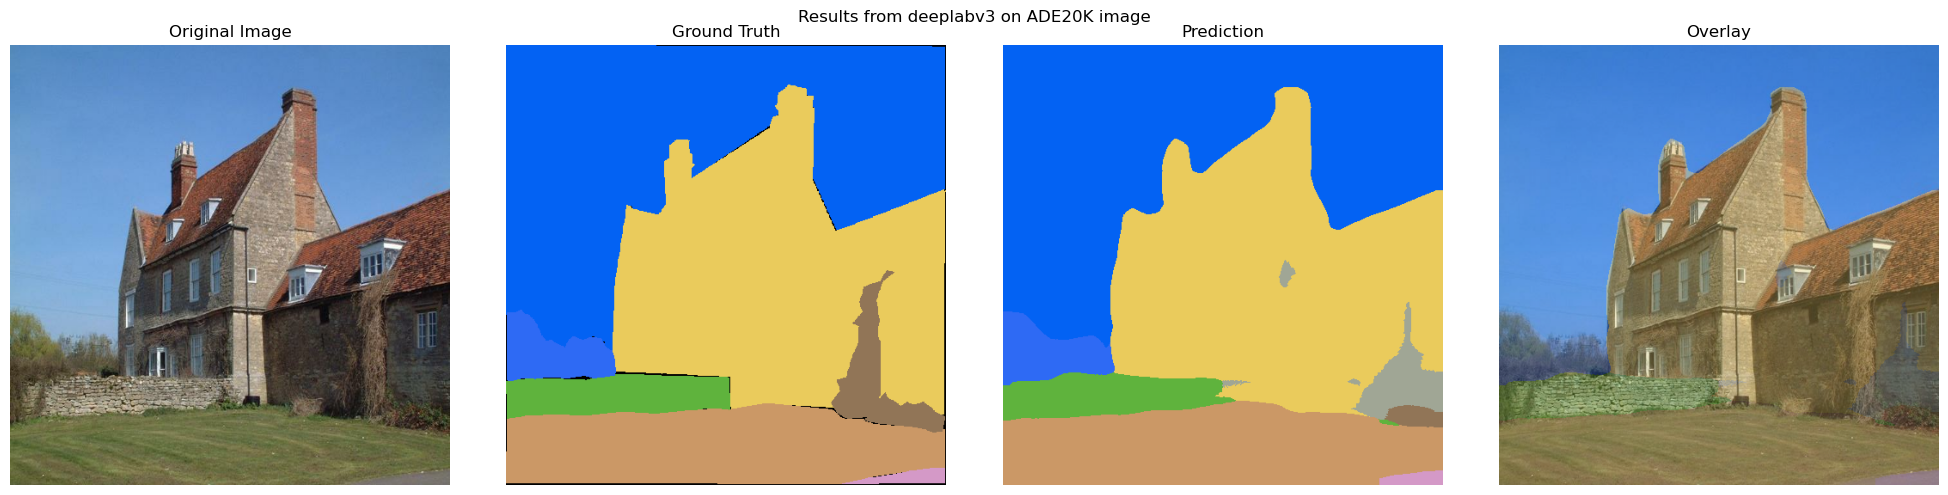

⏱️ Inference time: 432.18ms

📊 Predicted classes:
  Class 1: 10962 pixels (4.2%)
  Class 2: 93343 pixels (35.6%)
  Class 3: 101135 pixels (38.6%)
  Class 5: 6884 pixels (2.6%)
  Class 7: 995 pixels (0.4%)
  Class 10: 41379 pixels (15.8%)
  Class 18: 1367 pixels (0.5%)
  Class 26: 6079 pixels (2.3%)


In [34]:
# Load ADE20K dataset and process first image
try:
    # Load dataset
    dataset = load_ade20k_dataset('../datasets')
    
    # Get the first batch using take(1) and convert to numpy
    images, masks = next(iter(dataset.take(1)))
    
    # Process first image (remove batch dimension)
    image = images[0].numpy()
    mask = masks[0].numpy()
    
    # Run inference
    results = evaluate_single_image(model, image, true_mask=mask, model_name=MODEL_NAME)
    
    # Display results
    display_segmentation_results(results, f"Results from {MODEL_NAME} on ADE20K image")
    
except tf.errors.OutOfRangeError:
    print("Dataset is empty. Please make sure there are images in the ADE20K validation set.")
except Exception as e:
    print(f"Error loading dataset or running inference: {str(e)}")
    print("Please make sure the ADE20K dataset is available in the datasets directory")


## 3. Example 2: Arbitrary Image

Now let's try running inference on any image file.


In [35]:
def create_upload_widget():
    """Create and display an image upload widget with output area"""
    # Create output widget for displaying results
    output = widgets.Output()
    
    # Create upload widget
    upload = widgets.FileUpload(
        accept='image/*',  # Accept all image types
        multiple=False,    # Only allow single file selection
        description='Select Image',
        button_style='primary',
        layout=widgets.Layout(width='auto', height='auto')
    )
    
    def process_uploaded_image(change):
        """Process the uploaded image and run inference"""
        if not upload.value:
            return
            
        with output:
            # Clear previous output
            output.clear_output(wait=True)
            
            try:
                # Get the uploaded file data
                content = next(iter(upload.value))['content']  # Get content of first file
                
                # Convert to numpy array
                image = np.array(Image.open(io.BytesIO(content)))
                
                # Store original size for later
                original_height, original_width = image.shape[:2]
                
                # Convert RGBA to RGB if needed
                if len(image.shape) == 3 and image.shape[2] == 4:
                    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
                elif len(image.shape) == 2:
                    # Convert grayscale to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
                # Resize to 512x512 (model's expected input size)
                image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
                
                # Normalize image to [0,1] range
                image = image.astype(np.float32) / 255.0
                
                print(f"Processing image (resized from {original_width}x{original_height} to 512x512)")
                
                # Run inference
                results = evaluate_single_image(model, image, model_name=MODEL_NAME)
                
                # Display results
                display_segmentation_results(results, f"Results from {MODEL_NAME} on uploaded image")
                
            except Exception as e:
                print(f"Error processing image: {str(e)}")
                print("Please make sure to upload a valid image file")
            
            # Reset the upload widget by creating a new instance
            upload.value = ()  # This clears the selection
    
    # Register the callback
    upload.observe(process_uploaded_image, names='value')
    
    # Create a vertical box layout
    vbox = widgets.VBox([
        widgets.HTML("<h3>Upload an image for segmentation:</h3>"),
        upload,
        output
    ])
    
    # Display the widget
    display(vbox)

# Create and display the widget
create_upload_widget()
